In [11]:
# -*- coding: utf-8 -*-
"""
covariance_analyser

With this notebook I set out to process neuronal 
and bird song data from Crandall 2007 to produce a graph 
representing the covariance in some mannor.

These data were collected for the following study:

    Crandall, Shane R., Naoya Aoki, and Teresa A. Nick. 
    2007. “Developmental Modulation of the Temporal 
    Relationship Between Brain and Behavior.” Journal 
    of Neurophysiology 97 (1): 806–16. 
    doi:10.1152/jn.00907.2006.

These open data was downloaded from crcns.org, which
contains some additional information on the data.

Features of the audio were produced by processing the
.wav files in the data set with Sound Analysis Pro 2011.

The intention of this notebook was to produce code which
could process the data in such a way that further 
analysis would be simple

Created on Mon Jun 29 13:57:37 2015

@author: Alex Brebner
"""

'\ncovariance_analyser\n\nWith this notebook I set out to process neuronal \nand bird song data from Crandall 2007 to produce a graph \nrepresenting the covariance in some mannor.\n\nThese data were collected for the following study:\n\n    Crandall, Shane R., Naoya Aoki, and Teresa A. Nick. \n    2007. \xe2\x80\x9cDevelopmental Modulation of the Temporal \n    Relationship Between Brain and Behavior.\xe2\x80\x9d Journal \n    of Neurophysiology 97 (1): 806\xe2\x80\x9316. \n    doi:10.1152/jn.00907.2006.\n\nThese open data was downloaded from crcns.org, which\ncontains some additional information on the data.\n\nFeatures of the audio were produced by processing the\n.wav files in the data set with Sound Analysis Pro 2011.\n\nThe intention of this notebook was to produce code which\ncould process the data in such a way that further \nanalysis would be simple\n\nCreated on Mon Jun 29 13:57:37 2015\n\n@author: Alex Brebner\n'

In [1]:
##Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sp
import scipy.io.wavfile as wav
import scipy.signal as sgnp
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy import fftpack
from scipy import stats
import os
import csv
import math

%matplotlib inline

In [2]:
#Constants
sampling_freq = 44100 # sampling rate of the day 2007 data is 44.1 kHz
adult_birds = set(['blk161', 'o222', 'r87', 'w293',]) # names of the adult birds used in Crandall 2007
good_electrodes = {'blk161': ['e2'], 'o222': ['e1', 'e2'], 
                   'r87': ['e1', 'e2'], 'w293': ['e2']} # these are the "good electrodes" (RMS >= 3 x baseline RMS)

# work paths
data_dir = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007' 
r87 = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007\\r87\\sngr870119wtrig02-Apr135757\\sng162004_0119v4' # for testing purposes before path generator was made
blk161 = 'C:\\Users\\abre049.UOA\\Documents\\data\\Crandall 2007\\blk161\\sngblk1610308wtrigC23-Mar140834\\sng163839_0308v3.mat' # as above
blk161_syl_path = 'C:\\Users\\abre049.UOA\\Documents\\data\\blk161_syll_clust.csv'
blk161_feat_dir = 'C:\\Users\\abre049.UOA\\Documents\\data\\blk161_feature_data'

# home paths
# data_dir = 'C:\\Users\\Alex\\Documents\\Crandall2007data'
# blk161 = 'C:\\Users\\Alex\\Documents\\Crandall2007data\\blk161\\sngblk1610308wtrigC23-Mar140834\\sng163839_0308v3.mat'

#Load the data location

I want to have a way of feeding the data into python in such a way that I can easy change the scope of data. ie change from single 2-15sec recording to all the data from all birds. 

The data is stored like this: 
Crandall 2007[\__MACOSX[...], bird_name_x[...], bird_name_y[.DS_Store, day_a[...], day_b[wav[...], single_song_data_i, single_song_data_j, ...], ...], ...]

To do this I will make a function which will iterate through all the folders and files and store each subdirectory as dictionary, while ignoring the additional OSX meta-data and wav files. This can then be used to generate the urls of all data files.

In [3]:
def data_file_urls(data_dir):
    """
    Takes the path name of the directory containing bird song data returning a
    a dictionary of all songs.
    
    Parameters:
        data_dir = path name of the directory containing data. Data should be
        from Crandall 2007, downloaded from crcns.org and unzipped into this
        directory
        
    Return object:
        Dictionary where {dir: 'data_dir', bird: {day: set(['song_file.mat'])}}.
        Song file names are stored in unordered sets within a dictionary key of
        days within a dictionary key of bird. The outermost dictionary also 
        contains the directory of the data
    """
    data_urls = {} # dict that will be returned
    
    for bird in os.listdir(data_dir): # finds bird folders
        if bird != '__MACOSX': # ignores metadata for macs
            data_urls[bird] = {}
    for bird in data_urls.iterkeys():
        for day in os.listdir(os.path.join(data_dir, bird)): # finds day folders
            if day != '.DS_Store': # ignore metadata
                data_urls[bird][day] = set(os.listdir(os.path.join(data_dir, bird, day))) # finds files and compiles dictionaries
                data_urls[bird][day].discard('wavs') # ignore wav files
    data_urls['dir'] = data_dir # remeber the data_dir for easy access later
    return data_urls
    
song_locs = data_file_urls(data_dir) # song_locs is saved as a global variable

print 'Data directory:', song_locs['dir'], '\n'
print 'Bird folders:', song_locs.keys(), '\n'
print 'Day folders of blk161:', song_locs['blk161'].keys(), '\n'
print 'Song files eg of blk161:', song_locs['blk161']['sngblk1610305wtrig23-Mar120225']

Data directory: C:\Users\abre049.UOA\Documents\data\Crandall 2007 

Bird folders: ['blk161', 'Blue15', 'dir', 'r87', 'White293'] 

Day folders of blk161: ['sngblk1610308wtrigA23-Mar133853', 'sngblk1610308wtrigC23-Mar140834', 'sngblk1610303wtrigA23-Mar110608', 'sngblk1610302wtrig23-Mar104706', 'sngblk1610306wtrigB23-Mar124508', 'sngblk1610309wtrig23-Mar143025', 'sngblk1610306wtrigA23-Mar121557', 'sngblk1610308wtrigB23-Mar134644', 'sngblk1610307wtrigB23-Mar131559', 'sngblk1610305wtrig23-Mar120225', 'sngblk1610307wtrigA23-Mar125009'] 

Song files eg of blk161: set(['sng184151_0305v8.mat', 'sng184151_0305v4.mat', 'sng182330_0305v8.mat', 'sng182122_0305v4.mat', 'sng185025_0305v3.mat'])


#Path generator

In [4]:
def gen_path(bird, song):
    '''
    Helper function which takes the song file name 
    (as either a .wav or .mat) as named in the
    original data set and the bird name and returns 
    the path of the .mat file
    
    Parameters:
    
        bird - name of the bird as stored in song_locs
        song - name of the song file you want the path for.
            as either .wav or .mat, following the Crandall
            2007 data set naming convensions.
    
    Returns
    
        string with the path name of the file of interest
        
    Exceptions:
    
        'Song name not .wav or .mat'
    '''
    if song[-4:] == '.wav': # account for the different .wav or .mat naming convensions
        file_name = 'sng' + song[6:12] + '_' + song[1:5] + song[12:-4] + '.mat'
    elif song[-4:] == '.mat':
        file_name = song
    else:
        return 'Song name not .wav or .mat'
    for folder in song_locs[bird].keys(): # note needs access to song_locs as a global variable (or at least within the same scope)
        if folder[9:13] == file_name[10:14]: # identify which 'day' folder the file is in (note some days are split into 2 or 3 folders)
            if file_name in song_locs[bird][folder]:
                folder_name = folder
                break
    return song_locs['dir'] + '\\' + bird + '\\' + folder_name + '\\' + file_name
        
print '.wav eg:', gen_path('blk161', 'v0308t080339v10.wav')
print '.mat eg:', gen_path('blk161', 'sng091922_0308v3.mat')

.wav eg: C:\Users\abre049.UOA\Documents\data\Crandall 2007\blk161\sngblk1610308wtrigA23-Mar133853\sng080339_0308v10.mat
.mat eg: C:\Users\abre049.UOA\Documents\data\Crandall 2007\blk161\sngblk1610308wtrigB23-Mar134644\sng091922_0308v3.mat


#How do the raw data look?

In order to process the data I need to import it into python, and investigate the python objects type and shape.

The python module scipy has a function 'loadmat()' which can read .mat files

I decided to make a convention where data will be loaded outside of helper functions as to conserve memory and for easy of use

Data class:  <type 'dict'>
Keys:  ['sng', 'ref', '__header__', '__globals__', '__version__', 'e1', 'e3', 'e2']
Header:  MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Mar 23 14:28:55 2006
Globals:  []
Versions:  1.0
length of sng array: 164976


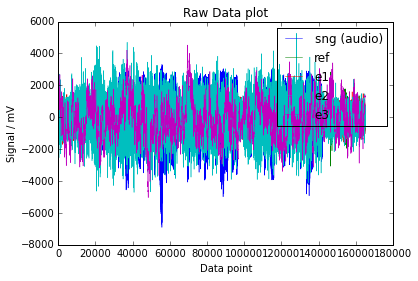

In [5]:
#Workspace
##data_url is now out of date, needs fix
def display_raw_data(data):
    '''
    Takes the data of one song file and prints or plots various information
    to gain an understanding of the object and data shapes
    '''
    print 'Data class: ', type(data) # what is the python data type?
    print 'Keys: ', data.keys()
    print 'Header: ', data['__header__']
    print 'Globals: ', data['__globals__']
    print 'Versions: ', data['__version__']
    print 'length of sng array:', len(data['sng']) # need to plot this as so long

    plt.plot(data['sng'], label='sng (audio)', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.plot(data['e1'][0], label='e1', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
    plt.plot(data['e3'][0], label='e3', linewidth=0.5)
    plt.legend()
    plt.title('Raw Data plot')
    plt.ylabel('Signal / mV')
    plt.xlabel('Data point')

display_raw_data(sp.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))) # load the data in the argument area.

#Listen to audio

To insure that the 'sng' array in the data are indeed songs I need to export them as a .wav file and listen to them. I will also need to subjectively compare these to the .wav file provided to insure they are indded of the same rendition.

scipy has a function to export .wav files

The raw data do indeed match the .wav files as compared by ear on multiple files

In [6]:
def make_wav_file(data):
    '''
    Takes a loaded .mat file and generates a .wav file from the raw audio data named audio.wav in the working directory
    '''
    sp.wavfile.write('audio.wav', sampling_freq, data)
    
song_data = sp.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))['sng']
# make_wav_file(sp.loadmat(song_data))

#What does one population electrode look like?

According to the study paper each bird had data recorded form a reference electrode, a eeg electrode and either one or two HVC electrodes.

According to the data description there is data for electodes called 'ref', 'e1', 'e2', 'e3'. According to the description e2 was "good" for all birds and o222 and w293 had "good" e1 electrodes. When plotted all the the e electrodes always has some signal however in blk161 and w293 the 'e1' had a homogenous signal. 'e3' had a significanlty different shape than the other 3 electrode recordings. 

My conclusion is that:
ref: reference electrode
e1: hvc electrode from o222 and w293, noise from the other two birds
e2: hvc electrodes from all birds
e3: eeg electrodes

In order to get a cleaner signal the difference of the recording electrode and reference electrode should be taken.

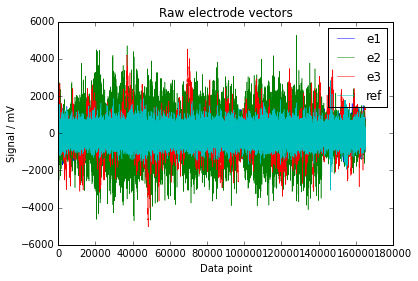

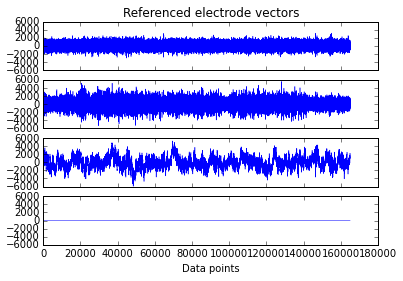

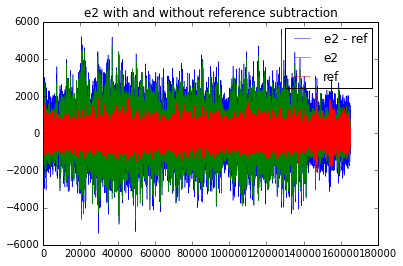

In [7]:
def ref_e(data, electrode='e2'):
    '''
    Returns the difference of the specified electrode and the reference electrode. Defaults to e2.
    Parameters:
        data = python dict of .mat data
        electrode = string of the desired electrode
        
    Return:
        1d np.array of refferenced electrode data
    '''
    return np.array(data[electrode][0]) - np.array(data['ref'][0])

def plot_electrode(data):
    '''
    takes the loaded .mat file of a song and plots raw electrode vectors, 
    referenced electrode vectors and and example of electrode data before 
    and after referencing
    
    Parameters:
        data = dict of sp.loadmat generated .mat data of one bird song recording
    '''
    
    plt.plot(data['e1'][0], label='e1', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
    plt.plot(data['e3'][0], label='e3', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.legend()
    plt.title('Raw electrode vectors')
    plt.ylabel('Signal / mV')
    plt.xlabel('Data point')
    plt.show()
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True)
    ax1.plot(ref_e(data, electrode='e1'), label='e1', linewidth=0.5)
    ax1.set_title('Referenced electrode vectors')
    ax2.plot(ref_e(data, electrode='e2'), label='e2', linewidth=0.5)
    ax3.plot(ref_e(data, electrode='e3'), label='e3', linewidth=0.5)
    ax4.plot(ref_e(data, electrode='ref'), label='ref', linewidth=0.5)
    ax4.set_xlabel('Data points')
    plt.show()
    
    plt.plot(ref_e(data, electrode='e2'), label='e2 - ref', linewidth=0.5)
    plt.plot(data['e2'][0], label='e2', linewidth=0.5)
#     plt.plot(ref_e(data, electrode='e2'), label='e2 - ref', linewidth=0.5)
    plt.plot(data['ref'][0], label='ref', linewidth=0.5)
    plt.title('e2 with and without reference subtraction')
    plt.legend()
    plt.show()

song_data = sp.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))
plot_electrode(song_data)


#Plot song

What does the raw bird song look like?

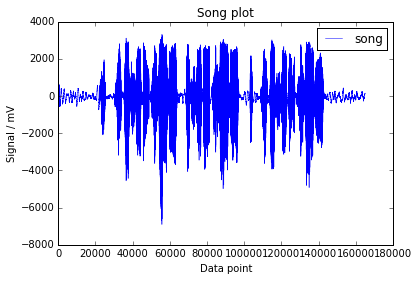

In [8]:
def plot_song(data, lw=0.5, plot_now=False):
    '''
    Takes raw song data and plots the raw audio component
    
    Parameters:
        data - sp.loadmat genereated dict of .mat file of raw song
        lw - line width
        plot_now - boolean. default is False which does not plt.show() so that other plots can be put on the same graph.
            True will plt.show() with labels
            
    Return: Nil
    '''
    plt.plot(data['sng'], label='song', linewidth=lw)
    if plot_now:
        plt.legend()
        plt.title('Song plot')
        plt.ylabel('Signal / mV')
        plt.xlabel('Data point')
        plt.show()
    
plot_song(sp.loadmat(gen_path('blk161', 'sng163839_0308v3.mat')), plot_now=True)

#Plot spectrogram

What does the spectrogram of a raw song look like?

Also, we were curious what the spectrogram of the population data would look like. We wondered if we would be able to identify patterns in the spectrogram which would represent specific neuron types (given that neuron types have unique action potential patterns.

processing ideas: plot in grayscale. print and view paper horizontally. cut frequencies > ~ 5000. plot log y axis. filter signal before fft.

In [1]:
def plot_spectrogram(data):
    '''
    Takes raw data and plots raw specgram using matplotlib
    
    Parameters:
        data = raw data in the form of a dict from sp.loadmat of .mat song file
    '''
    one_d_data = [idx[0] for idx in data]
    plt.specgram(one_d_data, Fs=sampling_freq)
    
# v0307t072941v2.wav
# sng163839_0308v3.mat
def electrode_specgram():
    song_data = sp.loadmat(gen_path('blk161', 'v0307t072941v2.wav'))
    plot_spectrogram(song_data['sng'])
    plt.title("song")
    plt.show()

    plt.specgram(e_bp_filter(ref_e(song_data, electrode='e2')), Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()

    plt.specgram(signal_filter(ref_e(song_data, electrode='e2')[:44100], data_type='e'), Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()

    song_data = sp.loadmat(gen_path('blk161', 'sng163839_0308v3.mat'))
    plot_spectrogram(song_data['sng'])
    plt.title("song")
    plt.show()

    plt.specgram(ref_e(song_data, electrode='e2'), Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()

    plt.specgram(ref_e(song_data, electrode='e2')[44100:88200], Fs=sampling_freq)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()

    plt.specgram(ref_e(song_data, electrode='e2')[44100:88200], Fs=sampling_freq, NFFT=256*2, noverlap=128*2)
    plt.title("e2")
    plt.ylabel('frequency')
    plt.xlabel('time / s')
    plt.show()
    
electrode_specgram()

NameError: global name 'sp' is not defined

#Import syllable data

SAP2011 was used to generate song features from the .wav files provided in the data set. A syllable was defined as continuous sound > 40 db amplitude. Syllables were manually checked to exclude noise. Only syllables with at least two preceeding introductory notes were chosen for bird blk161. Zebra finch default settings were used. Syllables were then clustered with SAP2011. These were exported with the backup function (as the export function was not working at the time) and the backup file was manually changed from .xls to .csv

In [10]:
def get_syl_data(syll_data_path):
    '''
    Takes the directories of the .cvs file with syllable data and cluster number (produced with SAP2011 backup function).
    Return a 2d list with data
    Parameters:
        syll_data_path - a directory containing the .cvs file produced by SAP2011 backup function
            with cols of song_name, start time, duration, mean_freq etc
    Returns:
        list of lists. first row contains the headings of the columns as strings. The remaining lists are the data as either
            strings or floats
    Exceptions: nil
    '''
    syl_data = [] # the return object
    with open(syll_data_path, 'r') as f: # opens the .csv file
        reader = csv.reader(f)
        headings = [] # will become the first row
        row_data = [] # used to make the table body
        row_numb = 0 # counter to keep track of which row as some data must be excluded as it is garbage
        for row in reader: # iterates through the .csv rows
            if row_numb >= 16 and row_numb < 61: # these row contain the heading information
                char_state = 0 # there is garbage characters around the useful information, this keeps track of the useful info
                col_head = ''
                for char in row[0]:
                    if char == "`": # data between the first two ` is the useful information
                        char_state += 1
                    elif char_state == 1: # only use useful info
                        col_head += char
                headings.append(col_head)
            elif row_numb == 61: # there are a few blank rows, use the first one to assign the headings into syl_data
                syl_data.append(headings)
            elif row_numb >= 70 and len(row) > 1: # identify the data body, ignoring empty rows
                for val in row: # cleans the data as there are useless chars arond the useful info
                    if val[0:3] == "  (":
                        row_data.append(float(val[3:])) #convert the numbers from strings to floats
                    elif val[:2] == " '":
                        row_data.append(val[2:-1]) # some info are strings
                    elif len(val) > 0:
                        row_data.append(float(val[1:])) # convert the numbers from strings to floats
            if len(row_data) > 0: # don't add empty rows to data
                syl_data.append(row_data)
            row_numb += 1
            row_data = []
        f.close()
    return syl_data

syl_data = get_syl_data(blk161_syl_path)
print syl_data[0:3]
# for syl in syl_data:
#     print syl[0]
    

[['recnum', 'serial_number', 'bird_ID', 'start_on', 'duration', 'mean_pitch', 'mean_peak_freq', 'mean_FM', 'mean_entropy', 'mean_goodness_of_pitch', 'mean_mean_frequency', 'mean_am2', 'mean_amplitude', 'mean_continuity_f', 'mean_continuity_t', 'mean_DAS', 'min_pitch', 'min_peak_freq', 'min_FM', 'min_entropy', 'min_meanFr', 'min_DAS', 'max_pitch', 'max_peak_freq', 'max_FM', 'max_amplitude', 'max_entropy', 'max_meanFr', 'max_DAS', 'max_continuity_f', 'max_continuity_t', 'var_pitch', 'var_FM', 'var_entropy', 'var_goodness_of_pitch', 'var_mean_frequency', 'var_am', 'month', 'day', 'hour', 'minute', 'second', 'cluster', 'file_name', 'comments'], [1.0, 38799.40538, 'blk161', 657.506, 84.8073, 529.0, 473.0, 46.0, -1.3, 342.6, 2874.0, 0.01908, 55.7, 88.96, 20.46, 41.09, 339.0, 473.0, 6.9, -2.0, 1308.0, 20.0, 3438.0, 473.0, 86.3, 63.0, -0.64, 4227.0, 64.0, -35.96, 42.33, 0.0, 400.0, 0.134026, 76900.0, 509000.0, 0.0193, 3.0, 23.0, 11.0, 15.0, 38.0, -2.0, 'v0307t072941v2.wav', "comments'"], [2.0,

#Import song feature arrays

Using SAP2011 the feature arrays were generated from the .wav files, with filters of 500 - 8000Hz and window of 1ms. Arrays were manually copy and pasted into an excel sheet (one for each syllable) and saved as an .csv file. features include 'Goodness_of_pitch', 'Wiener_entropy', 'Peak_frequency', 'Time', 'AM', 'Continuity_freq', 'Continuity_time', 'Amplitude', 'Pitch', 'Mean_frequency', 'Duration_of_state', 'FM'. Note that each file covers an entire motif and syllables must be identified by the time specefied in the syllable table.

In [11]:
def get_song_feat(path):
    '''
    Takes the path of .csv file produced by SAP2011 with the backup function which contains the set of arrays of song features
    Returns a dicitonary where keys are the feature name and values are a list of plots.
    Parameters:
        path of feature_table.csv
    Return:
        dict where {'song feature': [values]}.
    Exceptions:
        nil
    '''
    feat_arrays = {}
    with open(path, 'r') as f:
        reader = csv.reader(f)
        row_numb = 0
        dict_body = []
        for row in reader:
            if row_numb == 0:
                headings = row
                for en in headings:
                    dict_body.append([])
            elif row_numb > 1: # skip row two which is blank
                for idx in range(len(row)):
                    dict_body[idx].append(float(row[idx]))
            row_numb += 1
        f.close()
    for idx in range(len(headings)):
        feat_arrays[headings[idx]] = dict_body[idx]
    return feat_arrays
    
# testing = get_song_feat(blk161_feat_dir + '\\v0307t072941v2.csv')
# for y in testing:
#     if y != 'Time':
#         plt.plot(testing['Time'], testing[y], label=y)
# plt.legend()
# plt.show()
# plt.plot(testing['Amplitude'])
# plt.show()

testing = get_song_feat(blk161_feat_dir + '\\v0307t072941v2.csv')
print 'Column headings: ', testing.keys()


Column headings:  ['Goodness_of_pitch', 'Wiener_entropy', 'Peak_frequency', 'Time', 'AM', 'Continuity_freq', 'Continuity_time', 'Amplitude', 'Pitch', 'Mean_frequency', 'Duration_of_state', 'FM']


#Cut feature arrays to match syllable time

I needed to exctract the feature arrays corresponding to each syllable and then center them so that the center of each syllable is aligned to 0.

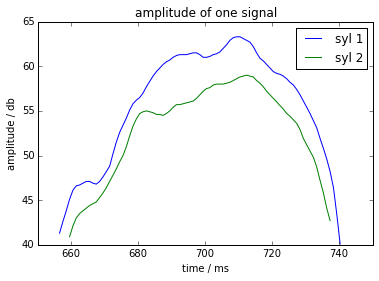

In [12]:
def cut_array(array_times, array_vals, start_time, duration):
    '''
    Take and array for the time axis and feature value axis 
    as well as the start time and duration of a syllable and 
    extracts the appropriate segment of array values returning 
    the time and values as a tuple
    
    Parameters:
        array_times - list of the time axis of a song feature
        array_vals - list of the song feature values
        start_time - the first time to extract
        duration - length of syllable
    
    Return:
        Tuple containing two list, first being the time values, 
        second being the syallable values of one syllable
    
    '''
    start_idx = 0
    stop_idx = 0
    for idx in range(len(array_times)):
        if array_times[idx] <= start_time - 0.1: # note that because the values to not match exactly the selection is rounded down to the hundreth of a microsecond
            start_idx = idx
        elif array_times[idx] <= start_time + duration - 1:# note that because the values to not match exactly the selection is rounded up
            stop_idx = idx
    return array_times[start_idx: stop_idx], array_vals[start_idx: stop_idx]
            
syl_data = get_syl_data(blk161_syl_path)
feat_data = get_song_feat(blk161_feat_dir + "\\" + syl_data[1][-2][:-3] + 'csv')
x_vals, y_vals = cut_array(feat_data['Time'], feat_data['Amplitude'], syl_data[1][3], syl_data[1][4])
plt.plot(x_vals, y_vals, label='syl 1')
feat_data = get_song_feat(blk161_feat_dir + "\\" + syl_data[5][-2][0:-3] + 'csv')
x_vals, y_vals = cut_array(feat_data['Time'], feat_data['Amplitude'], syl_data[5][3], syl_data[5][4])
plt.plot(x_vals, y_vals, label='syl 2')
plt.title('amplitude of one signal')
plt.legend()
plt.xlabel('time / ms')
plt.ylabel('amplitude / db')
plt.show()


#Center x values

We decided to align syllables by the center point. The reasoning behind this method is that it is simple and more intuative to interpret. There are obvious limitation to this method in that due to the arbritrary nature of syllable definition (is greater then 40db, and the potential for syllables to be lengthened by backround noise or shorteded by birds facing away from the speakers The alignment will not be perfect. An alternative way of alignment could be aligning by largest correlation.

In [13]:
def center_x(x_vals, units='ms'):
    '''
    takes an array of time or sample values and aligns the 
    middle value to 0. assumes uniform distribution. If 
    samples are given the output value is converted to ms
    
    Parameters:
        x_vals - a list containing either time values in ms or sample number corresponding to a syllable array
        units - string either 'ms' or 'samples' denoting the unit of x_vals, default to 'ms'
    
    Return:
        list with time values centered to zero
        
    Exceptions:
        'invalid argument for units, need "ms" or "samples"'
    '''
    new_x = []
    left_shift = float(min(x_vals)) + ((max(x_vals) - min(x_vals)) * 0.5) # how far to move left
    if units=='samples':
        for val in x_vals:
            new_x.append((val - left_shift) / sampling_freq * 0.001) # converts to ms
    elif units == 'ms':
        for val in x_vals:
            new_x.append(val - left_shift)
    else:
        return 'invalid argument for units, need "ms" or "samples"'
    return new_x
        
print center_x([1,2,3,4,5])

[-2.0, -1.0, 0.0, 1.0, 2.0]


#Plot a feature of a cluster

In order to test all the preceeding code I decided to try to plot a feature (amplitude) of all the clusters of a song. This would be a good test most of the previous code. I decided to combine this code with a function that could make a list of a feature of all the syllables in a cluster. 

I decided to make this function a generator to conserve memory

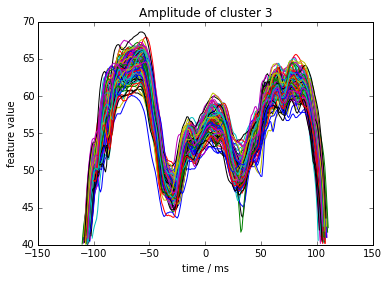

In [14]:
def clust_gen(syl_path, clust_num, feature, feat_dir, plot=False):
    '''
    Generator returning a 2d list of centered x and y vals of the feature for the cluster specified. 
    Can also plot arrays.
    
    Parameters:
        syl_path - string, path to the syllable table of a bird
        clust_num - iteger, cluster number as generated by SAP2011
        feature - string, heading of feature of interest as per feature table from SAP2011
        feat_dir - directory folder for the feature .csv files
        plot - boolean, default to False, True will plot the arrays
    
    Returns:
        Generator yielding:
            3d list, idx_0 is a list with the centered time values, 
            idx_1 is a list with the corresponding feature values 
            and idx_3 is a integer of the idx of the syllable in the cluster
    '''
    syl_data = get_syl_data(syl_path)
    sylls = []
    for idx in range(len(syl_data[0])): # learn which column is clusters
        if syl_data[0][idx] == 'cluster':
            cluster_idx = idx
    for idx in range(len(syl_data[1:]) + 1): # find the syllables of the desired cluster
        if syl_data[idx][cluster_idx] == clust_num:
            sylls.append(idx)
    for idx in sylls:
        feat_data = get_song_feat(feat_dir + "\\" + syl_data[idx][-2][0:-3] + 'csv') # look up data of the syllable
        x_vals, y_vals = cut_array(feat_data['Time'], feat_data[feature], syl_data[idx][3], syl_data[idx][4]) # extract array of that syllable from feature data
        x_vals = center_x(x_vals)
        yield [x_vals, y_vals, idx]
        if plot:
            plt.plot(x_vals, y_vals)
    if plot:
        plt.title(feature + ' of cluster ' + str(clust_num))
        plt.xlabel('time / ms')
        plt.ylabel('feature value')

x = []
y = []
for pairs in clust_gen(blk161_syl_path, 3, 'Amplitude', blk161_feat_dir, plot=True):
    x.append(pairs[0])
    y.append(pairs[1])
plt.show()

#Match X values to median

In order to compare the values of each feature I needed to either use windows or interpolate to match x values. This second technique had the advantage of cutting the longer arrays to the shortest array so that a correlation coefficent could be generated. Windows had the disadvantage of sometimes including syllables twice in one window (due to rounding errors from previous processing). Therefore I chose to interpolate to match x values.

In [15]:
def shortest_array(x_arrays):
    '''
    Function to be used in conjunction with match_x. Returns the the shortest list in a list of lists
    '''
    shortest_idx = -1
    shortest_val = 999999999999.9
    for idx in range(len(x_arrays)):
        if x_arrays[idx][-1] < shortest_val:
            shortest_idx = idx
            shortest_val = x_arrays[idx][-1]
    return x_arrays[shortest_idx]

old x len 208 , first val -103.265 , last val 103.265
new x len 204 , first val -101.265 , last val 101.265


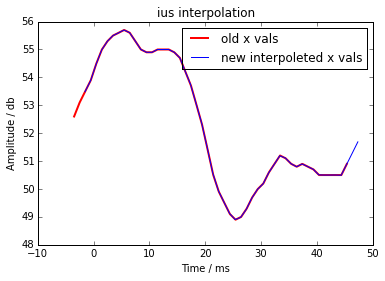

In [16]:
def match_x(ref_x, x_array, y_array):
    '''
    uses InterpolatedUnivariateSpline to match the x values (time) of an array with that of another shorter array.
    
    Parameters:
        ref_x - list, x values to map to
        x_array - list, x values of original graph
        y_array - list, y values of original graph
    
    Return:
        list of new y values matched to the ref_x values
    '''
    temp = ius(x_array, y_array) # ius may not be appropriate, but looks like it does a good job
    new_y = temp(ref_x)
    return new_y
    
x = []
y = []
for pairs in clust_gen(blk161_syl_path, 3, 'Amplitude', blk161_feat_dir):
    x.append(pairs[0])
    y.append(pairs[1])
y_vals =  match_x(shortest_array(x), x[0], y[0]) # can use shortest_array() as an argument
print 'old x len', len(x[0]), ', first val', x[0][0], ', last val', x[0][-1]
print 'new x len', len(shortest_array(x)), ', first val', shortest_array(x)[0], ', last val', shortest_array(x)[-1]
plt.plot(x[0][100:150], y[0][100:150], color='r', label='old x vals', linewidth='2.0')
plt.plot(shortest_array(x)[100:150], y_vals[100:150], label='new interpoleted x vals')
plt.legend()
plt.title('ius interpolation')
plt.xlabel('Time / ms')
plt.ylabel('Amplitude / db')
plt.show()

#Make median array

In order to quantify the variation of a song feature I needed to create an "average" waveform. The average can be either mean of median.

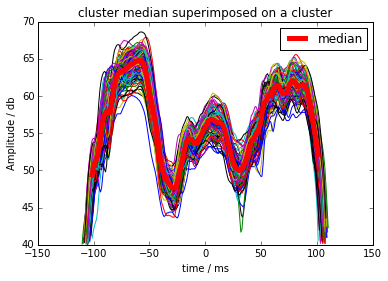

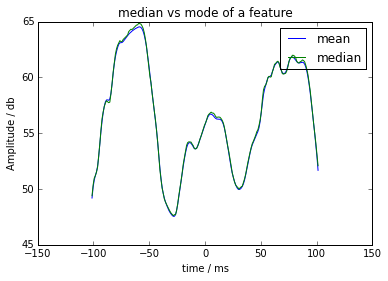

In [17]:
def make_median_array(x_array, y_arrays, average='median'):
    '''
    Takes list of lists with respective x and y values of a 
    graph and finds the median (or mode) of y value at each x value. 
    Arrays must be of the same length and value (ie interpolated)
    
    Parameters:
        x_array - 1d list, the x values (time) of all the different y value arrays
        y_array - 2d list, each sub list are the values (floats) for a feature of one syllable
        average - string, either 'median' or 'mode. default is 'median'
    
    Return:
        np.array object of the "average" y values
    '''
    median_y = []
    for idx in range(len(x_array)):
        y_vals = []
        for array in y_arrays:
            y_vals.append(array[idx])
        if average == 'median':
            median_y.append(np.median(y_vals))
        elif average == 'mean':
            median_y.append(np.mean(y_vals))
    return median_y
    
x = []
y = []
for pairs in clust_gen(blk161_syl_path, 3, 'Amplitude', blk161_feat_dir, plot=True):
    x.append(pairs[0])
    y.append(pairs[1])
shortest_x_array = shortest_array(x)
for idx in range(len(x)):
    y[idx] = match_x(shortest_x_array, x[idx], y[idx])
median_y = make_median_array(shortest_x_array, y, average='median')
plt.plot(shortest_x_array, median_y, label='median', linewidth='5.0', color='r') # plot median on the clusters
plt.title('cluster median superimposed on a cluster')
plt.xlabel('time / ms')
plt.ylabel('Amplitude / db')
plt.legend()
plt.show()

foo = make_median_array(shortest_x_array, y, average='mean') # plot median vs mean for comparison
bar = make_median_array(shortest_x_array, y, average='median')
plt.plot(shortest_x_array, foo, label='mean')
plt.plot(shortest_x_array, bar, label='median')
plt.legend()
plt.title('median vs mode of a feature')
plt.xlabel('time / ms')
plt.ylabel('Amplitude / db')
plt.show()

#Quantify varience

NumPy has a function called corrcoef which is able to calculate the percentage correlation between two graphs. 
Need to redo this as correlation is not variance

In [18]:
def calc_corr(ref, array):
    return np.corrcoef([ref, array])[0][1]

x = []
y = []
for pairs in clust_gen(blk161_syl_path, 3, 'Amplitude', blk161_feat_dir):
    x.append(pairs[0])
    y.append(pairs[1])
shortest_x_array = shortest_array(x)
for idx in range(len(x)):
    y[idx] = match_x(shortest_x_array, x[idx], y[idx])
median_y = make_median_array(shortest_x_array, y, average='median')
print calc_corr(median_y, y[0])
print calc_corr(median_y, y[1])
print calc_corr(median_y, y[2])
print ":)"

corr_coefs = []
for y_vals in y:
    corr_coefs.append(calc_corr(median_y, y_vals))

0.968869101316
0.969883578113
0.956927146226
:)


#Savitzky-Golay smoothing filter

Day 2008 paper specifies that they used the following filter:

Savitzky-Golay smoothing filter with 4th order polynomial fit and 50 ms frame size

I will try to implement this with the SciPy.Signal module. This filter will hopefull give me a nice amplitude envelope for the electrode data. 

C:\Users\abre049.UOA\AppData\Local\Continuum\Anaconda\lib\site-packages\scipy\signal\_savitzky_golay.py:130: RuntimeWarning: invalid value encountered in power
  A = x ** order


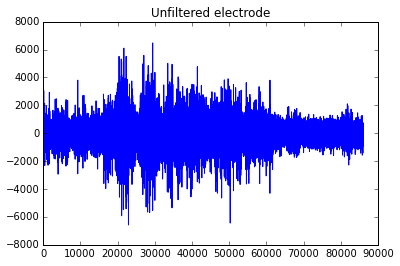

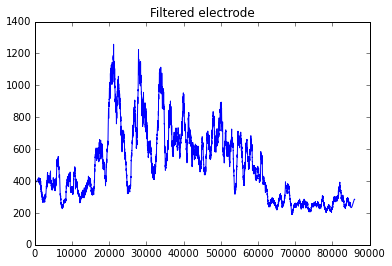

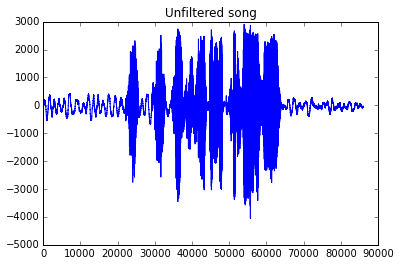

<function matplotlib.pyplot.show>

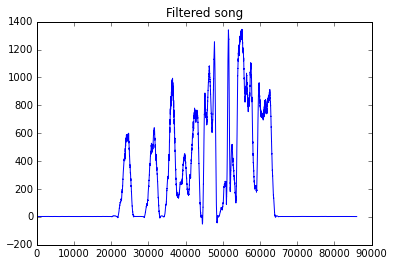

In [19]:
def signal_filter(array, data_type):
    '''
    Filters signals as per the Day 2008 processing. That is applied a band-pass butterworth filter, 
    rectifier and Savitzky-Golay filter in order to obtain amplitude envelopes from signals.
    
    For electrode signals band-pass = 300-6000 Hz, Savitzky-Golay filter frame = 50 ms
    For audio signals band=pass = 1000-8000Hz, Savitzky-Golay filter frame = 20 ms
    
    Savitzky-Golay filters are 4th order.
    
    Parameters:
        array - list, y-values to be filtered
        data_type - string, "e" = electrode, "sng" = song
        
    Return:
        np.array - filtered data
    '''
    nyquist = sampling_freq / 2.0
    if data_type == 'e': # e stands for electrode ie the neuronal data
        b, a = sgnp.butter(1, [300/nyquist, 6000/nyquist], btype='bandpass')
        filtrate = sgnp.filtfilt(b, a, array)
        filtrate = abs(filtrate)
        window = int(50 * sampling_freq * 0.001)
        if window%2 == 0:
            window += 1
        filtrate = sgnp.savgol_filter(filtrate, window, 4, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        return filtrate
    
    elif data_type == 'sng': # sng stands for song ie audio data
        b, a = sgnp.butter(1, [1000 / nyquist, 8000 / nyquist], btype='bandpass')
        filtrate = sgnp.filtfilt(b, a, array)
        filtrate = abs(filtrate)
        window = int(20 * sampling_freq * 0.001)
        if window%2 == 0:
            window += 1
        filtrate = sgnp.savgol_filter(filtrate, window, 4, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        return filtrate

y = sp.loadmat(gen_path('blk161', syl_data[1][-2]))['e2'][0]
filtrate = signal_filter(y, 'e')
plt.plot(y)
plt.title('Unfiltered electrode')
plt.show()
plt.plot(filtrate)
plt.title('Filtered electrode')
plt.show()

temp_y = sp.loadmat(gen_path('blk161', syl_data[1][-2]))['sng']
y = [val[0] for val in temp_y]
filtrate = signal_filter(y, 'sng')
plt.plot(y)
plt.title('Unfiltered song')
plt.show()
plt.plot(filtrate)
plt.title('Filtered song')
plt.show

#Do the same for electrodes

#Extract electrode data
need to add code to deal with birds with 2 good electrodes
need to add code to normalise data to electrodes
Need to rectify and smooth signal to get good correlation

v0307t072941v2.wav 657.506 84.8073
9549 9549


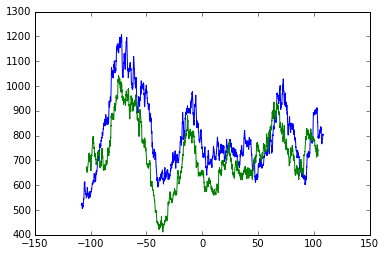

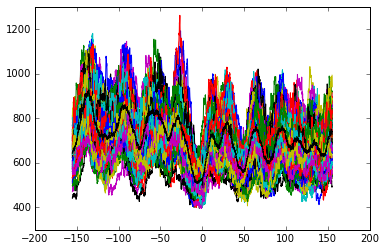

0.801022352985


In [27]:
def get_elec_data(song_data, syl_start, syl_dur, offset=50, electrode='e2'):
    first_sample = int((syl_start - offset) * sampling_freq * 0.001)
    last_sample = int((syl_start + syl_dur - offset) * sampling_freq * 0.001)
    
    e_data = np.array(song_data[electrode][0])
    ref_data = np.array(song_data['ref'][0])
    e_data = e_data - ref_data
    filtrate = signal_filter(e_data, 'e')
#     filtrate2 = signal_filter(ref_data, 'e')
#     filtrate = filtrate1 - filtrate2
    e_array = filtrate[first_sample: last_sample + 1]
    
    x_vals = center_x(range(first_sample, last_sample + 1))
    x_in_ms = []
    for val in x_vals:
        x_in_ms.append(val / float(sampling_freq) * 1000.0)
    
    return x_in_ms, e_array    

# def remove_bad_signals(filtered_signals):
#     bad_signal_idx = []
#     for idx in range(len(filtered_signals)):
#         if max(filtered_signals[idx]) > 1500 or max(filtered_signals[idx]) < 400:
#             bad_signal_idx.append(idx)

print syl_data[1][-2], syl_data[1][3], syl_data[1][4]
x_vals1, e_array1 = get_elec_data(sp.loadmat(gen_path('blk161', syl_data[2][-2])), syl_data[2][3], syl_data[2][4], electrode='e2')
print len(x_vals1), len(e_array1)
# plt.subplot(211)
plt.plot(x_vals1, e_array1)
# plt.subplot(212)
x_vals2, e_array2 = get_elec_data(sp.loadmat(gen_path('blk161', syl_data[6][-2])), syl_data[6][3], syl_data[6][4], electrode='e2')
plt.plot(x_vals2, e_array2)
plt.show()

x = []
y = []
syl_data_idx = []
for a, b, idx in clust_gen(blk161_syl_path, 1, 'Amplitude', blk161_feat_dir):
    syll = syl_data[idx]
    x_vals, y_vals = get_elec_data(sp.loadmat(gen_path('blk161', syll[-2])), syll[3], syll[4])
    if max(y_vals) < 1500 and max(y_vals) > 500:
        x.append(x_vals)
        y.append(y_vals)
        syl_data_idx.append(idx)
shortest_x_array = shortest_array(x)
for idx in range(len(x)):
    y[idx] = match_x(shortest_x_array, x[idx], y[idx])
median_y = make_median_array(shortest_x_array, y, average='median')
for array in y:
    plt.plot(shortest_x_array, array)
plt.plot(shortest_x_array, median_y)
plt.show()
print calc_corr(median_y, y[0])

# >5000 --> syl_data_idx[78, 84, 86, 88]
# >1500 --> syl_data_idx[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 78, 84, 85, 86, 88]


The above it to help visualise filter design
The following is a unified filter for use in the later analysis

In [ ]:
odds = []
for idx in range(len(y)):
    if max(y[idx]) > 1500:
        odds.append(idx)
print odds

smalls = []
for idx in range(len(y)):
    if max(y[idx]) < 2000:
        smalls.append(idx)
print len(smalls)

for val in [74, 78, 84, 86, 88]:
    plot_spectrogram(sp.loadmat(gen_path('blk161', syl_data[syl_data_idx[val]][-2]))['sng'])
    print val
    plt.show()
    print syl_data[syl_data_idx[val]][3:5]
    plt.plot(sp.loadmat(gen_path('blk161', syl_data[val][-2]))['e2'][0], label='e2')
    plt.plot(sp.loadmat(gen_path('blk161', syl_data[val][-2]))['e3'][0], label='e3')
#     plt.plot(sp.loadmat(gen_path('blk161', syl_data[val][-2]))['e1'][0], label='e1')
#     plt.plot(sp.loadmat(gen_path('blk161', syl_data[val][-2]))['ref'][0], label='ref')
    plt.legend()
    plt.show()
    
    
print syl_data[1][-2], syl_data[1][3], syl_data[1][4]
x_vals1, e_array1 = get_elec_data(sp.loadmat(gen_path('blk161', syl_data[syl_data_idx[74]][-2])), syl_data[syl_data_idx[74]][3], syl_data[syl_data_idx[74]][4], electrode='e2')
print len(x_vals1), len(e_array1)
# plt.subplot(211)
plt.plot(x_vals1, e_array1)
# plt.subplot(212)
x_vals2, e_array2 = get_elec_data(sp.loadmat(gen_path('blk161', syl_data[syl_data_idx[78]][-2])), syl_data[syl_data_idx[78]][3], syl_data[syl_data_idx[78]][4], electrode='e2')
plt.plot(x_vals2, e_array2)
plt.show()

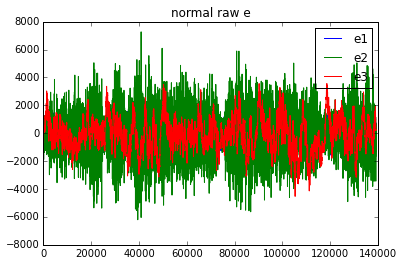

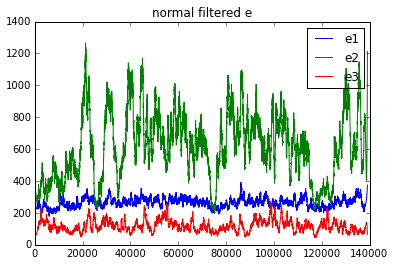

IndexError: list index out of range

In [21]:
foo = sp.loadmat(gen_path('blk161', syl_data[100][-2]))
plt.plot(foo['e1'][0], label='e1')
plt.plot(foo['e2'][0], label='e2')
plt.plot(foo['e3'][0], label='e3')
plt.title('normal raw e')
plt.legend()
plt.show()

plt.plot(signal_filter(foo['e1'][0], 'e'), label='e1')
plt.plot(signal_filter(foo['e2'][0], 'e'), label='e2')
plt.plot(signal_filter(foo['e3'][0], 'e'), label='e3')
plt.title('normal filtered e')
plt.legend()
plt.show()

foo = sp.loadmat(gen_path('blk161', syl_data[syl_data_idx[70]][-2]))
plt.plot(foo['e1'][0], label='e1')
plt.plot(foo['e2'][0], label='e2')
plt.plot(foo['e3'][0], label='e3')
plt.title('raw e signal from abnormal data')
plt.legend()
plt.show()

plt.plot(signal_filter(foo['e1'][0], 'e'), label='e1')
plt.plot(signal_filter(foo['e2'][0], 'e'), label='e2')
plt.plot(signal_filter(foo['e3'][0], 'e'), label='e3')
plt.title('filtered e signal from abnormal data')
plt.legend()
plt.show()

foo_song = [val[0] for val in foo['sng']]
plt.specgram(foo_song, label='song')
plt.title('song from abnormal e')
plt.legend()
plt.show()

By plotting the raw data of the abnormal traces it seems to me that the problem is with the electrode recordings. These data shall be expluded from the analysis.

#Scattergram of electrode variance vs feature variance for each motif

In [ ]:
def calc_covariance(bird, clust, feature, plot=False):
    coefficients = [[],[]]
    # feature arrays
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    for syl in clust_gen(blk161_syl_path, clust, 'Amplitude', blk161_feat_dir): # will need to make function which takes into accout the bird argument after testing
        feat_x.append(syl[0])
        feat_y.append(syl[1])
        temp_syl_data = syl_data[syl[2]]
        temp_e_x, temp_e_y = get_elec_data(sp.loadmat(gen_path(bird, temp_syl_data[-2])), 
                                           temp_syl_data[4], temp_syl_data[4], electrode=good_electrodes[bird][0])
        e_x.append(temp_e_x)
        e_y.append(temp_e_y)
    shortest_feat_x = shortest_array(feat_x)
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)):
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx])
        e_y[idx] = sg_filter(match_x(shortest_e_x, e_x[idx], e_y[idx])) # interpolate the electrode values then filter
    feat_ave_y = make_median_array(shortest_feat_x, feat_y, average='median')
    e_ave_y = make_median_array(shortest_e_x, e_y, average='median')
    
    for idx in range(len(feat_x)):
        coefficients[0].append(calc_variance(feat_ave_y, feat_y[idx]))
        coefficients[1].append(calc_variance(e_ave_y, e_y[idx]))
    
    return coefficients


covariance_coef = calc_covariance('blk161', 3, 'Amplitude')
print 'done'
print covariance_coef

In [ ]:
plt.scatter(covariance_coef[0], covariance_coef[1])
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(covariance_coef[0], covariance_coef[1])
print slope, intercept, r_value, p_value, std_err

#Serial linear regressions:
##song feature - average_sf vs electrode potential - average_e for each ms

These regressions should tell us if there is a correlation between neaural activity differing from the average and all the various song features independant of time and whether such a correlation is direct or inverse.



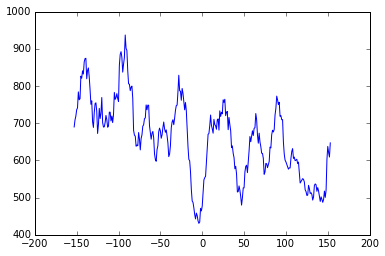

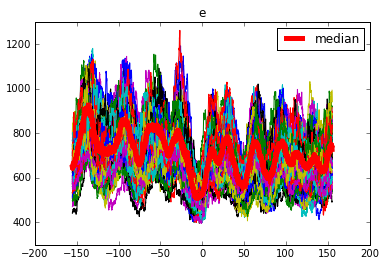

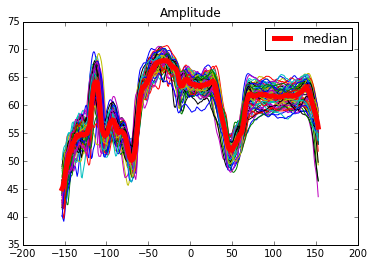

[]

In [29]:
def deviation_from_mean(bird, clust, feature, plot=True):
    coefficients = [[],[]]
    # feature arrays
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    for syl in clust_gen(blk161_syl_path, clust, feature, blk161_feat_dir): # will need to make function which takes into accout the bird argument after testing
        
        temp_syl_data = syl_data[syl[2]]
        temp_e_x, temp_e_y = get_elec_data(sp.loadmat(gen_path(bird, temp_syl_data[-2])), 
                                           temp_syl_data[3], temp_syl_data[4], electrode='e2') # good_electrodes[bird][0]
        if max(temp_e_y) < 1500 and max(temp_e_y) > 500: # selects against bad traces
            e_x.append(temp_e_x) 
            e_y.append(temp_e_y)
            feat_x.append(syl[0])
            feat_y.append(syl[1])
    
    shortest_feat_x = range(int(shortest_array(feat_x)[0] + 1), int(shortest_array(feat_x)[-1]))
    common_x = shortest_feat_x
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)):
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx])
        e_y[idx] = match_x(shortest_e_x, e_x[idx], e_y[idx])
    
    time_bins = []
    for val in shortest_feat_x:
        time_bins.append(val - 0.5)
    time_bins.append(shortest_feat_x[-1] + 0.5)
    e_y_ms_mean = []
    for array in e_y:
        bin_means, bin_edges, binnumber = stats.binned_statistic(shortest_e_x, array, statistic='mean', bins=time_bins)
        e_y_ms_mean.append(bin_means)
    plt.plot(common_x[:], e_y_ms_mean[0][:])
#     plt.plot(common_x, e_y_ms_mean[1])
#     plt.plot(common_x, e_y_ms_mean[2])
    plt.show()
    
#     for array in e_y
#         e_y_ms_mean = []
#         for idx in range(len(shortest_e_x)):
#             for val in shortest_feat_x:
#                 one_ms_bin = []
#                 for idx in range(len(shortest_e_x)):
#                     if 
#         take the values half way between the adjacent seconds
#         average the values
#         asign this value to the corresponding ms
    
    feat_ave_y = make_median_array(shortest_feat_x, feat_y, average='median')
    e_ave_y = make_median_array(shortest_e_x, e_y, average='median')
    
    for idx in range(len(e_x)):
        plt.plot(shortest_e_x, e_y[idx])
    plt.plot(shortest_e_x, e_ave_y, linewidth=5, color='r', label='median')
    plt.title('e')
    plt.legend()
    plt.show()
    
    for idx in range(len(e_x)):
        plt.plot(shortest_feat_x, feat_y[idx])
    plt.plot(shortest_feat_x, feat_ave_y, linewidth=5, color='r', label='median')
    plt.title(feature)
    plt.legend()
    plt.show()
    
    return []
    
deviation_from_mean('blk161', 1, 'Amplitude')

1007.71 1091.5195


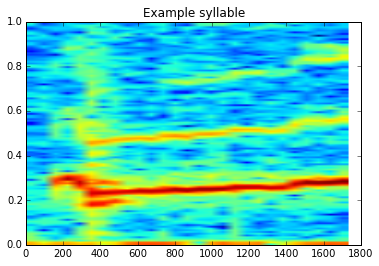

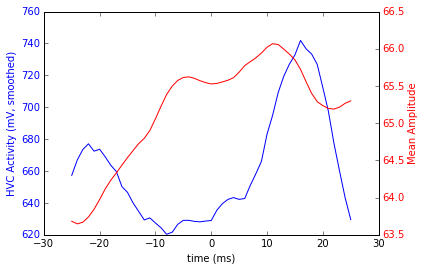

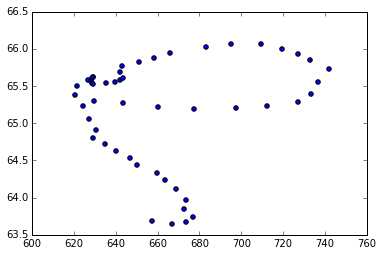

slope 0.00216623293093
intercept 63.7451745598
r_value 0.109477540735
p_value 0.444422483833
std_err 0.0028097247479
773.243 980.771


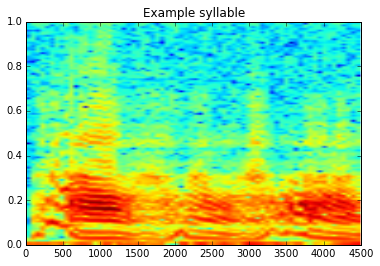

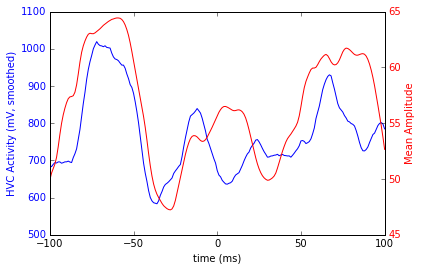

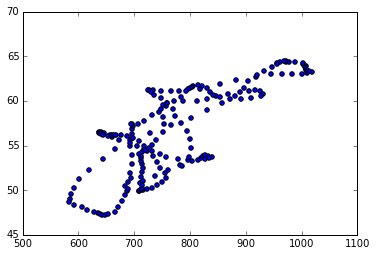

slope 0.0344471807356
intercept 29.934768873
r_value 0.773428419972
p_value 2.89739987465e-41
std_err 0.0020013201486


In [44]:
def replicate_fig4_day2008(bird, cluster, feature):
    feat_x = []
    feat_y = []
    e_x = []
    e_y = []
    for syl in clust_gen(blk161_syl_path, cluster, feature, blk161_feat_dir): # will need to make function which takes into accout the bird argument after testing
        
        temp_syl_data = syl_data[syl[2]]
        temp_e_x, temp_e_y = get_elec_data(sp.loadmat(gen_path(bird, temp_syl_data[-2])), 
                                           temp_syl_data[3], temp_syl_data[4], electrode='e2') # good_electrodes[bird][0]
        if max(temp_e_y) < 1500 and max(temp_e_y) > 500: # selects against bad traces
            e_x.append(temp_e_x) 
            e_y.append(temp_e_y)
            feat_x.append(syl[0])
            feat_y.append(syl[1])
    shortest_feat_x = range(int(shortest_array(feat_x)[0] + 1), int(shortest_array(feat_x)[-1]))
    common_x = shortest_feat_x
    shortest_e_x = shortest_array(e_x)
    for idx in range(len(e_x)):
        feat_y[idx] = match_x(shortest_feat_x, feat_x[idx], feat_y[idx])
        e_y[idx] = match_x(shortest_e_x, e_x[idx], e_y[idx])
        
    time_bins = []
    for val in shortest_feat_x:
        time_bins.append(val - 0.5)
    time_bins.append(shortest_feat_x[-1] + 0.5)
    e_y_ms_mean = []
    for array in e_y:
        bin_means, bin_edges, binnumber = stats.binned_statistic(shortest_e_x, array, statistic='mean', bins=time_bins)
        e_y_ms_mean.append(bin_means)
    
#     specgram
    found_example = False
    for idx in range(len(syl_data[0])): # learn which column is clusters
        if syl_data[0][idx] == 'cluster':
            cluster_idx = idx
    for idx in range(len(syl_data[1:]) + 1): # find the syllables of the desired cluster
        if found_example:
            break
        if syl_data[idx][cluster_idx] == cluster:
            song_array = [val[0] for val in sp.loadmat(gen_path(bird, syl_data[idx][-2]))['sng']]
            print syl_data[idx][3], syl_data[idx][3] + syl_data[idx][4]
            plt.specgram(song_array[int(syl_data[idx][3]*44.1): int((syl_data[idx][3] + syl_data[idx][4])*44.1)])
            plt.title('Example syllable')
            plt.show()
            found_example = True
    
#     feature
#         mean
#             line
    mean_e_y = []
    mean_feat_y = []
    for idx in range(len(common_x)):
        temp_e_bin = [val[idx] for val in e_y_ms_mean]
        temp_feat_bin = [val[idx] for val in feat_y]
        mean_e_y.append(np.mean(temp_e_bin))
        mean_feat_y.append(np.mean(temp_feat_bin))
        
    fig, e_ax = plt.subplots()
    e_ax.plot(common_x, mean_e_y, 'b-')
    e_ax.set_xlabel('time (ms)')
    e_ax.set_ylabel('HVC Activity (mV, smoothed)', color='b')
    for tl in e_ax.get_yticklabels():
        tl.set_color('b')
        
    f_ax = e_ax.twinx()
    f_ax.plot(common_x, mean_feat_y, 'r-')
    f_ax.set_ylabel('Mean Amplitude', color='r')
    for tl in f_ax.get_yticklabels():
        tl.set_color('r')
    plt.show()
    
    plt.scatter(mean_e_y, mean_feat_y)
    plt.show()

    slope, intercept, r_value, p_value, std_err = stats.linregress(mean_e_y, mean_feat_y)
    print 'slope', slope
    print 'intercept', intercept
    print 'r_value', r_value
    print 'p_value', p_value
    print 'std_err', std_err
    
    

#             scatter
#         variance
#             line
#             scatter
    
replicate_fig4_day2008('blk161', 2, 'Amplitude')
replicate_fig4_day2008('blk161', 3, 'Amplitude')